In [1]:
import numpy as np
import scipy.linalg as la
import pickle

from scipy.optimize import minimize
from itertools import product

from qiskit import *
from qiskit.quantum_info.states.random import random_density_matrix
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace

import matplotlib.pyplot as plt
from mpl_axes_aligner import shift
plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.size": 10}
)

In [2]:
def dictionary_of_actions(num_qubits):
    dictionary = dict()
    i = 0
    for c, x in product(range(num_qubits),
                        range(1, num_qubits)):
        dictionary[i] =  [c, x, num_qubits, 0]
        i += 1
    for r, h in product(range(num_qubits),
                           range(1, 4)):
        dictionary[i] = [num_qubits, 0, r, h]
        i += 1
    return dictionary

def make_circuit_qiskit(action, qubits):
    ctrl = action[0]
    targ = (action[0] + action[1]) % qubits
    rot_qubit = action[2]
    rot_axis = action[3]
#     print(1)
    if ctrl < qubits:
        circuit.cx([ctrl], [targ])
    if rot_qubit < qubits:
        if rot_axis == 1:
            circuit.rx(0, rot_qubit) # TODO: make a function and take angles
        elif rot_axis == 2:
            circuit.ry(0, rot_qubit)
        elif rot_axis == 3:
            circuit.rz(0, rot_qubit)
        else:
            stop
    return circuit

In [4]:
qubits, rank, seed, seed_agent = 2,4,1,100
episodes = 10000
tolerance = 1e-5
test_train = 'train'
data = np.load(f'results/global_COBYLA/h_s_{qubits}_rank_{rank}_{seed}/summary_{seed_agent}.npy',allow_pickle=True)[()]

In [5]:
succ_ep_info_dict = {}
success_ep, success_ep_error = [], []
average_err = 0
for ep_no in range(episodes):
    data_error_last = data[test_train][ep_no]['errors'][-1]
    if data_error_last <= tolerance:
        success_ep.append(ep_no)
        success_ep_error.append(data_error_last)
        average_err += data_error_last
average_err /= len(success_ep)
print(f'First successful episode: {success_ep[0]} and error {round(success_ep_error[0],6)}, total successful episode: {len(success_ep)}')

succ_ep_info_dict['succ_ep_list'] = success_ep
succ_ep_info_dict['succ_ep_err_list'] = success_ep_error

with open(f'plot_data/{qubits}_qubit_mixed_rank_{rank}_agent_seed_{seed_agent}_succ_ep_data.p', 'wb') as fp:
    pickle.dump(succ_ep_info_dict, fp)

x = [data[test_train][ep_no]['actions'] for ep_no in success_ep]
circuit_info_dict = {}
depth_list = []
oneq_gate_list = []
twoq_gate_list = []
gate_num_list = []
for succ_ep in success_ep:
    actions = data[test_train][succ_ep]['actions']
    circuit = QuantumCircuit(qubits)
    for a in actions:
        action = dictionary_of_actions(qubits)[a]
        final_circuit = make_circuit_qiskit(action, qubits)
    gate_info = final_circuit.count_ops()
    key_list = gate_info.keys()
    one_gate, two_gate = 0,0
    for k in key_list:
        if k == 'cx':
            two_gate += gate_info[k]
        else:
            one_gate += gate_info[k]

    twoq_gate_list.append(two_gate)
    oneq_gate_list.append(one_gate)
    gate_num_list.append(one_gate+two_gate)        
    depth_list.append(final_circuit.depth())

circuit_info_dict['depth_list'] = depth_list
circuit_info_dict['oneq_gate_list'] = oneq_gate_list
circuit_info_dict['twoq_gate_list'] = twoq_gate_list
circuit_info_dict['gate_num_list'] = gate_num_list
with open(f'plot_data/{qubits}_qubit_mixed_rank_{rank}_agent_seed_{seed_agent}_circuit_data.p', 'wb') as fp:
    pickle.dump(circuit_info_dict, fp)

First successful episode: 29 and error 7e-06, total successful episode: 991


In [26]:
print(f'The average depth is: {np.mean(depth_list)}, minimum depth: {min(depth_list)}, 1st-depth: {depth_list[0]}, 100-depth: {np.mean(depth_list[0:100])}')
print(f'The average gate count: ROT={np.mean(oneq_gate_list)},CX={np.mean(twoq_gate_list)}')
print(f'The min gate count: ROT={oneq_gate_list[gate_num_list.index(min(gate_num_list))]},CX={twoq_gate_list[gate_num_list.index(min(gate_num_list))]}')
success_ep_error[gate_num_list.index(min(gate_num_list))]

The average depth is: 13.425832492431887, minimum depth: 10, 1st-depth: 15, 100-depth: 13.86
The average gate count: ROT=15.169525731584258,CX=3.7386478304742683
The min gate count: ROT=12,CX=3


9.603757840648264e-06

In [6]:
succ_ep = success_ep[gate_num_list.index(min(gate_num_list))]
# succ_ep = success_ep[-1]
thetas = data['train'][succ_ep]['opt_ang']
thetas = list(thetas[-1])

In [7]:
def eigenvals_func(theta, rdm, ansatz):
    """Return the eigenvalues"""
    qc_eigenvals = ansatz
    dm_evo = rdm.evolve(qc_eigenvals)
    dm_evo = dm_evo.data
    diagnls = list((np.diagonal(dm_evo)).real)
    diag_A = []
    diag_A.append(diagnls)
    return diag_A, dm_evo, qc_eigenvals

In [8]:
import scipy.linalg as la
state_data = []
rdm = random_density_matrix(2**qubits, rank = rank, seed = 1)
state_to_diag_gen = rdm
true_eig = np.sort(la.eig(state_to_diag_gen)[0].real)
err_list = []
gates = oneq_gate_list[gate_num_list.index(min(gate_num_list))] + \
        twoq_gate_list[gate_num_list.index(min(gate_num_list))]
gates_list = range(1, gates+1)
inf_eig_list = []
for g in gates_list:
    final_circuit = QuantumCircuit.from_qasm_str(data['train'][succ_ep]['save_circ'][-1])
    ansatz =QuantumCircuit(qubits)
    for i in final_circuit.data:
        if i[0].name == 'cx':
            ansatz.cx(i[1][0].index, i[1][1].index)
        if i[0].params != [0]:
            if i[0].name == 'rx':
                ansatz.rx(i[0].params[0], i[1][0].index)
            elif i[0].name == 'ry':
                ansatz.ry(i[0].params[0], i[1][0].index)
            elif i[0].name == 'rz':
                ansatz.rz(i[0].params[0], i[1][0].index)

    ansatz.data = ansatz[:g]
    inf_eig = np.sort(eigenvals_func(thetas, state_to_diag_gen, ansatz)[0])[0]
    inf_eig_list.append(inf_eig)
    #### ERROR IN EIGENVALUE CALCULATION ####
    err = 0
    for eigno in range(2**qubits):
        err += np.abs(inf_eig[eigno] - true_eig[eigno])**2
    err_list.append(err)

/tmp/ipykernel_1442482/2038071203.py:19: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  ansatz.rx(i[0].params[0], i[1][0].index)
/tmp/ipykernel_1442482/2038071203.py:21: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  ansatz.ry(i[0].params[0], i[1][0].index)
/tmp/ipykernel_1442482/2038071203.py:23: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  ansatz.rz(i[0].params[0], i[1][0].index)
/tmp/ipykernel_1442482/2038071203.py:16: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  ansatz.cx(i[1][0].index, i[1][1].inde

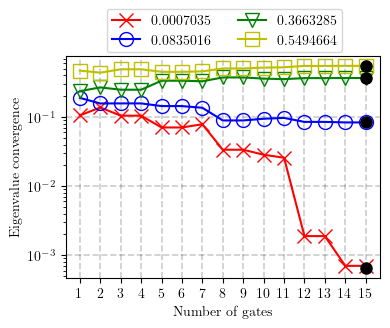

In [9]:
line_type = ['r-x', 'b-o', 'g-v', 'y-s', 'k-8', 'c-X', 'm-D', '-H']
fig, ax = plt.subplots( 1, 1, sharey=True, figsize = (4, 3.5))
# ax = fig.add_subplot(111)
for eigel in range(2**qubits):
    x = np.asarray(inf_eig_list)[:,eigel]
#     print(len(x), len(list(range(1,gates,1)))) 
    ax.semilogy(list(range(1,gates+1,1)), x, line_type[eigel], markerfacecolor='none', ms=10, label = f'{round(x[-1],7)}')

for true_eigel in true_eig:
    ax.plot([gates], [true_eigel], 'ko', ms=8)

ax.set_xticks(list(range(1,gates+1,1)))
# org = 0.45  # Origin
# pos = 5.7  # Position the origins is aligned
# expand = True  # Switch the aligning method
# shift.xaxis(ax, pos, org)
ax.legend(ncol = 2, bbox_to_anchor=[0.9, 1.24])
ax.set_xlabel('Number of gates')
ax.set_ylabel('Eigenvalue convergence')
ax.grid(color='k', linestyle='--', linewidth=1.2, alpha = 0.2)
fig.tight_layout()
# plt.savefig(f'plot/{qubits}_qubits_eigenvalue_convergence_seed_{seed_agent}.pdf')
# plt.savefig(f'plot/{qubits}_qubits_eigenvalue_convergence_seed_{seed_agent}.png')